# <span style="color:blue">Importing libraries</span>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import requests
import os.path
import re

# <span style="color:blue">Data reading from web</span>

### <span style="color:red">The code below takes quite long to be run and sometimes it hangs.</span>  

It is for illustration of initial data collection only. **For practice, the saved csv files should be used.**

### Reading tables arranged by UFO observation date

This returns a list of dataframes, the `[0]` element being a dataframe describing the tables of UFO observations by date. The `Reports` column contains the list of the available tables.  
The dataframes corresponding to each shape can then be retrieved from
`http://www.nuforc.org/webreports/ndxs{date}.html`. The `{date}` in the url should be empty for `Unspecified` date, otherwise in the `YYYYMM` format.

In [ ]:
tables_by_date_list = pd.read_html('http://www.nuforc.org/webreports/ndxevent.html')

The code below saves each table as local html file for further import if necessary. This is done because reading of numerous files from the server is unstable and sometimes fails. Saving the html files can be restarted if needed - only the missing files will be downloaded during subsequent runs. Overall, **the downloading takes about 25 minutes**.

In [ ]:
if not os.path.exists('by_date'):
        os.mkdir('by_date')

for date in tables_by_date_list[0].Reports:
    if date == 'UNSPECIFIED / APPROXIMATE':
        url = 'http://www.nuforc.org/webreports/ndxe.html'
        file = 'by_date/unspecified.html'
    else:
        url = f'http://www.nuforc.org/webreports/ndxe{date[-4:]}{date[:2]}.html'
        file = 'by_date/' + date.replace('/', '_') + '.html'
    
    if not os.path.isfile(file):
        r = requests.get(url, allow_redirects=True)
        open(file, 'wb').write(r.content)
        # optional text output to track the process
        #print(file)

The code below is for reading the tables from url directly to the dataframe. If often fails; when successful, **<ins>the reading takes about an hour</ins>**

In [ ]:
ufo_by_date = []

for date in tables_by_date_list[0].Reports:
    #print(f'Reading data for shape = {shape_name}...')
    if date == 'UNSPECIFIED / APPROXIMATE':
        temp_df = pd.read_html(f'http://www.nuforc.org/webreports/ndxe.html')[0]
        temp_df['Date_label'] = date
        ufo_by_date.append(temp_df)
    else:
        temp_df = pd.read_html(f'http://www.nuforc.org/webreports/ndxe{date[-4:]}{date[:2]}.html')[0]
        temp_df['Date_label'] = date
        ufo_by_date.append(temp_df)
    # optional text output to monitor the process
    #print(f'Reading data for date = {date} done!')

finish_reading_by_date = pd.Timestamp.now()    
    
ufo_raw_date = pd.concat(ufo_by_date)

Saving the dataframe for further use

In [ ]:
ufo_raw_date.reset_index(drop=True, inplace=True)

In [ ]:
ufo_raw_date.to_csv("ufo_raw_date.csv")

### Reading tables arranged by UFO shape

This code returns a list of dataframes, the `[0]` element being a dataframe showing UFOs by type.  
The dataframes corresponding to each shape can then be retrieved from
`'http://www.nuforc.org/webreports/ndxs{shape_name}.html'`. The `{shape}` in the url should be empty for `Unspecified` shape.

In [ ]:
tables_by_shape_list = pd.read_html('http://www.nuforc.org/webreports/ndxshape.html')

Subsequent code is similar to reading by date. The data reading to dataframe takes **<ins>about 20 minutes</ins>** and is not always stable. The data reading to file takes about **4 minutes**.

In [ ]:
if not os.path.exists('by_shape'):
        os.mkdir('by_shape')

for shape_name in tables_by_shape_list[0].Reports:
    if shape_name == 'Unspecified':
        url = 'http://www.nuforc.org/webreports/ndxs.html'
        file = 'by_shape/unspecified.html'
    else:
        url = f'http://www.nuforc.org/webreports/ndxs{shape_name}.html'
        file = 'by_shape/' + shape_name + '.html'
    
    if not os.path.isfile(file):
        r = requests.get(url, allow_redirects=True)
        open(file, 'wb').write(r.content)
        # optional text output to monitor the process
        print(file)

In [ ]:
ufo_by_shape = []

for shape_name in tables_by_shape_list[0].Reports:
    if shape_name == 'Unspecified':
        temp_df = pd.read_html(f'http://www.nuforc.org/webreports/ndxs.html')[0]
    else:
        temp_df = pd.read_html(f'http://www.nuforc.org/webreports/ndxs{shape_name}.html')[0]
    ufo_by_shape.append(temp_df)
    # optional text output to monitor the process
    #print(f'{shape_name} done!')

ufo_raw_shape = pd.concat(ufo_by_shape)

In [ ]:
ufo_raw_shape.to_csv("ufo_raw_shape.csv")

### Reading information about the states (USA and Canada)

Taking information from wikipedia: [USA](https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States) and [Canada](https://en.wikipedia.org/wiki/Provinces_and_territories_of_Canada')

We will need the states population and area (total and land ones) for further analysis.

In [2]:
USA_wiki = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States'

tables_states_list = pd.read_html(USA_wiki)

The first table about the USA states

In [22]:
states = tables_states_list[0]
states.head(1)

Flag, name andpostal abbreviation[12]  \
  Flag, name andpostal abbreviation[12]   
0                               Alabama   

                                               Cities              \
  Flag, name andpostal abbreviation[12].1     Capital Largest[16]   
0                                      AL  Montgomery  Birmingham   

  Ratification oradmission[C] Population[14] Total area[15]          \
  Ratification oradmission[C] Population[14]            mi2     km2   
0                Dec 14, 1819        5024279          52420  135767   

  Land area[15]         Water area[15]       Numberof Reps.  
            mi2     km2            mi2   km2 Numberof Reps.  
0         50645  131171           1775  4597              7

In [23]:
%%capture

# Leaving area in km^2
states = states.iloc[:, [0, 1, 5, 7, 9]]
states.columns = ['Name', 'Abbreviation', 'Population', 'Total_area', 'Land_area']

# Removing a note mark in the names
states.Name = states.Name.str.replace('[D]', '', regex=False)

states.Population = states.Population.astype('int64')

For further merging, the `Population`, `Total_area`, and `Land_area` should be numeric.

In [24]:
states.dtypes

Name            object
Abbreviation    object
Population       int64
Total_area       int64
Land_area        int64
dtype: object

Adding information of District of Columbia

In [25]:
DC = tables_states_list[1]

DC

Name andpostal abbreviation[12]                                    \
  Name andpostal abbreviation[12] Name andpostal abbreviation[12].1   
0            District of Columbia                                DC   

        Established Population[14] Total area[15]      Land area[15]       \
        Established Population[14]            mi2  km2           mi2  km2   
0  Jul 16, 1790[17]         689545             68  176            61  158   

  Water area[15]     Numberof Reps.  
             mi2 km2 Numberof Reps.  
0              7  18           1[E]

In [26]:
# Information about District of Columbia

DC = DC.iloc[:, [0, 1, 3, 4, 6]]
DC.columns = ['Name', 'Abbreviation', 'Population', 'Total_area', 'Land_area']

In [27]:
DC.dtypes

Name            object
Abbreviation    object
Population       int64
Total_area       int64
Land_area        int64
dtype: object

In [28]:
states = pd.merge(states, DC, how='outer')

Adding information about USA territories

In [29]:
territories = tables_states_list[2]
territories.head(1)

Name andpostal abbreviation[12]                                    \
  Name andpostal abbreviation[12] Name andpostal abbreviation[12].1   
0                  American Samoa                                AS   

         Capital Acquired[19]          Territorial status[20] Population[F]  \
         Capital Acquired[19]          Territorial status[20] Population[F]   
0  Pago Pago[21]         1900  Unincorporated, unorganized[G]    57,400[22]   

  Total area[15]       Land area[15]      Water area[15]       Numberof Reps.  
             mi2   km2           mi2  km2            mi2   km2 Numberof Reps.  
0            581  1505            76  198            505  1307           1[E]

In [30]:
%%capture

territories = territories.iloc[:, [0, 1, 5, 7, 9]]
territories.columns = ['Name', 'Abbreviation', 'Population', 'Total_area', 'Land_area']

# Removing coomments and useless commas
territories.Population = territories.Population\
        .astype('str')\
        .str.replace('\[..\]', '', regex=True)\
        .str.replace(',', '', regex=False)\
        .astype('int64')

In [31]:
territories.dtypes

Name            object
Abbreviation    object
Population       int64
Total_area       int64
Land_area        int64
dtype: object

In [32]:
states = pd.merge(states, territories, how='outer')

Adding information about Canada states

In [33]:
# States of Canada

canada = pd.read_html('https://en.wikipedia.org/wiki/Provinces_and_territories_of_Canada')[1]
canada = canada.iloc[:-1, [0, 1, 6, 7, 8]]
canada.columns = ['Name', 'Abbreviation', 'Population', 'Total_area', 'Land_area']
canada.Name = canada.Name.str.replace('[b]', '', regex=False)

In [34]:
states = pd.merge(states, canada, how='outer')

Adding information about Canada territories

In [35]:
# Territories of Canada

canada_territories = pd.read_html('https://en.wikipedia.org/wiki/Provinces_and_territories_of_Canada')[2]
canada_territories = canada_territories.iloc[:-1, [0, 1, 6, 7, 8]]
canada_territories.columns = ['Name', 'Abbreviation', 'Population', 'Total_area', 'Land_area']

In [36]:
states = pd.merge(states, canada_territories, how='outer')

In [37]:
states

,Name,Abbreviation,Population,Total_area,Land_area
0,Alabama,AL,5024279,135767,131171
1,Alaska,AK,733391,1723337,1477953
2,Arizona,AZ,7151502,295234,294207
3,Arkansas,AR,3011524,137732,134771
4,California,CA,39538223,423967,403466
...,...,...,...,...,...
64,Alberta,AB,4444277,642317,19531
65,Newfoundland and Labrador,NL,520286,373872,31340
66,Northwest Territories,NT,44991,1183085,163021
67,Yukon,YT,42596,474391,8052


In [38]:
states.to_csv('states.csv')

# <span style="color:blue">Data reading from local files</span>

In [39]:
ufo_by_date = pd.read_csv('ufo_raw_date.csv', index_col=0)

In [40]:
ufo_by_shape = pd.read_csv('ufo_raw_shape.csv', index_col=0)

In [41]:
states = pd.read_csv('states.csv', index_col=0)

# <span style="color:blue">Data cleaning</span>

Number of rows of the dataframes imported from tables arranged by UFO shape and by observation date is the same. Additional column in `ufo_by_date` is the manually introduced `Date_label` column.

In [42]:
ufo_by_date.shape, ufo_by_shape.shape

((134841, 8), (134841, 7))

Datasets collected by shape and by date are identical (result of the first merge is empty), but there are a few duplicates (result of the second merge is longer than the initial dataframe).

In [43]:
pd.merge(left=ufo_by_date, right=ufo_by_shape, how='outer', indicator=True)\
    .query('_merge != "both"').shape

(0, 9)

In [44]:
pd.merge(left=ufo_by_date, right=ufo_by_shape, how='outer', indicator=True)\
    .query('_merge == "both"').shape

(134847, 9)

We will further work with `ufo_raw_date` to keep "manual" date labels.

In [45]:
# making a copy to preserve source data
ufo = ufo_by_date.copy()

In [46]:
ufo

,Date / Time,City,State,Shape,Duration,Summary,Posted,Date_label
0,7/7/21 01:23,Moscow,ID,Light,30 min,Object moving across sky west to east that was...,7/31/21,07/2021
1,6/23/21 20:00,Medina,TN,Unknown,15 seconds,Unknown bright object disappears in a cloudles...,7/31/21,06/2021
2,6/22/21 01:00,Senji (India),NaN,Flash,15 seconds,I have that ufo video video as recorded 43 sec...,7/31/21,06/2021
3,6/21/21 19:30,York City (Brooklyn),NY,Circle,5 min6,A round white object (sphere) zoomed quickly i...,7/31/21,06/2021
4,6/21/21 14:45,San Jose,CA,Cylinder,10 Seconds,Capsule/Cylinder shaped object.,7/31/21,06/2021
...,...,...,...,...,...,...,...,...
134836,09?/?/1975,Oscoda,MI,Unknown,2-3 min,Funny flashing lights that hovered then just d...,6/6/00,UNSPECIFIED / APPROXIMATE
134837,NaN,Santa Maria,CA,Circle,19:00,Watching Sunday or Monday night football went ...,1/31/20,UNSPECIFIED / APPROXIMATE
134838,NaN,Rule,TX,Unknown,15 minutes,Unusual sounds and starlight distortion defini...,8/19/12,UNSPECIFIED / APPROXIMATE
134839,NaN,Graham,WA,Disk,2 minutes,Driving west on 224th looked right saw large c...,6/4/14,UNSPECIFIED / APPROXIMATE


In [47]:
ufo.dtypes

Date / Time    object
City           object
State          object
Shape          object
Duration       object
Summary        object
Posted         object
Date_label     object
dtype: object

We should consider converting `Date / Time` and `Posted` columns to datetime format.
On top of that, the column name with slash and spaces is not convenient.

In [48]:
ufo.rename(columns={'Date / Time': 'Observed'}, inplace=True)

In [49]:
round(sum(ufo.Date_label == 'UNSPECIFIED / APPROXIMATE') / ufo.shape[0] , 4)

0.0027

Parsing of poorly formatted dates/times is a complicated issue, but these are less than 0.3% of the observations. Hence, the solution is to remove such rows.

Then, we will remove too old observations (say, before 1900). This will resolve the issue of limited range of the `pd.datetime` type; moreover, these observations are not reliable and too scarce to affect the conclusions.

Since year is coded by two last digits, we will extract it from the `Date_label` column. A new `Year` column will be created instead of just query because we will then use it to modify the `Observed` values

In [51]:
%%capture

ufo = ufo.query('Date_label != "UNSPECIFIED / APPROXIMATE"')

ufo['Year'] = ufo.Date_label.apply(lambda x: int(x[-4:]))

ufo = ufo.query("Year >= 1900")

Without the following insertion of complete year, '68' would be converted to '2068'

In [52]:
times = []

for row in ufo.itertuples():
    date_complete_year = re.sub('/(.. )', '/' + str(row.Year) + ' ', row.Observed)
    times.append(date_complete_year)

ufo['Observed'] = pd.to_datetime(times, format="%m/%d/%Y %H:%M", errors='coerce')

About 1.3% of the dates/times were not complete, even though not marked as 'UNSPECIFIED / APPROXIMATE"'  

An example of such entry is given below (time are missing)

In [53]:
round(ufo.Observed.isnull().sum() / ufo.shape[0], 3)

0.013

In [55]:
pd.DataFrame({
                'as imported': ufo_by_date.loc[134435, :],
                'working': ufo.loc[134435, :]
             })

,as imported,working
City,Meeting Creek (Canada),Meeting Creek (Canada)
Date / Time,12/24/14,NaN
Date_label,12/1914,12/1914
Duration,NaN,NaN
Observed,NaN,NaT
Posted,7/7/17,7/7/17
Shape,NaN,NaN
State,SK,SK
Summary,"I initially submitted this several years ago, ...","I initially submitted this several years ago, ..."
Year,NaN,1914


In the case of `Posted` date, conversion to `datetime` is ambiguous anyway, but we will do it (maybe we will not use this column at all)

In [56]:
ufo.Posted = pd.to_datetime(ufo.Posted, format="%m/%d/%y", errors='coerce')

We don't need `Date_label` and `Year` columns any more.

In [58]:
ufo.drop(columns=['Date_label', 'Year'], inplace=True)

Checking non-null data

There are 49 totally incomplete observations (null data in `Observed`, `City`, `State`, `Shape`, and `Duration` columns). Since we do not aim at analyzing textual data, these observations will be removed.

In [60]:
ufo[ufo[['Observed', 'City', 'Shape', 'State', 'Duration']].isnull().sum(axis=1) == 5].shape[0]

49

In [61]:
ufo = ufo[ufo[['Observed', 'City', 'Shape', 'State', 'Duration']].isnull().sum(axis=1) < 5]

Working with `States` column: we will find the states abbreviations which are not in the `states` dataframe and correct the errors in data input

In [62]:
ufo.query('State not in @states.Abbreviation.values').query('not State.isnull()').State.value_counts()

PQ    102
NF     43
SA     41
YK      6
Fl      5
QB      1
Ca      1
M0      1
Name: State, dtype: int64

* PQ is another assignment of Quebec (QC)
* NF stands for Newfoundland and Labrador (which is NL in `ufo` dataset)
* SA is for Sounth Australia (will keep it in the dataframe as is)
* YK seems to stand for Yukon (YT)
* Fl is misprinted FL (Florida)
* QB seems to be Quebec (QC) as well
* M0 is misprinted MO
* Ca is misprinted CA

In [63]:
new_state = {
                'State': {'PQ': 'QC',
                          'NF': 'NL',
                          'SA': np.nan,
                          'YK': 'YT',
                          'Fl': 'FL',
                          'QB': 'QC',
                          'M0': 'MO',
                          'Ca': 'CA'}
            }

ufo = ufo.replace(new_state)

Now we will analyze the duplicates

4 cases have complete duplicates in the data

In [65]:
ufo[ufo.duplicated(['Observed', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'], keep=False)]\
    .sort_values(by=['Observed', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'])

,Observed,City,State,Shape,Duration,Summary,Posted
30165,2015-11-15 05:20:00,Reno,NV,Triangle,15 seconds,Black triangle. Only discernible by observing ...,2015-12-10
30167,2015-11-15 05:20:00,Reno,NV,Triangle,15 seconds,Black triangle. Only discernible by observing ...,2015-12-10
14406,2019-03-16 20:45:00,Virginia Beach,VA,Circle,5 minutes,Orange orb. ((anonymous report)),2019-03-21
14407,2019-03-16 20:45:00,Virginia Beach,VA,Circle,5 minutes,Orange orb. ((anonymous report)),2019-03-21
3200,2020-09-14 06:53:00,Aliquippa,PA,NaN,NaN,MADAR Node 68,2020-11-05
3201,2020-09-14 06:53:00,Aliquippa,PA,NaN,NaN,MADAR Node 68,2020-11-05
8538,NaT,Grand Junction,CO,NaN,NaN,MADAR Node 75 A number of anomalies this day,2020-01-31
8557,NaT,Grand Junction,CO,NaN,NaN,MADAR Node 75 A number of anomalies this day,2020-01-31
8581,NaT,Grand Junction,CO,NaN,NaN,MADAR Node 75 A number of anomalies this day,2020-01-31
8601,NaT,Grand Junction,CO,NaN,NaN,MADAR Node 75 A number of anomalies this day,2020-01-31


4 more observations differ only in the Posted date

In [66]:
ufo[ufo.duplicated(['Observed', 'City', 'State', 'Shape', 'Duration', 'Summary'], keep=False)]\
    .sort_values(by=['Observed', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'])

,Observed,City,State,Shape,Duration,Summary,Posted
30165,2015-11-15 05:20:00,Reno,NV,Triangle,15 seconds,Black triangle. Only discernible by observing ...,2015-12-10
30167,2015-11-15 05:20:00,Reno,NV,Triangle,15 seconds,Black triangle. Only discernible by observing ...,2015-12-10
20683,2017-08-12 22:30:00,Mount Pleasant,OH,Flash,12 minutes,White flashing light moving irregularly throug...,2017-08-24
20682,2017-08-12 22:30:00,Mount Pleasant,OH,Flash,12 minutes,White flashing light moving irregularly throug...,2017-09-05
15061,2019-01-05 14:00:00,Detroit,MI,Flash,10 minutes,We witnessed 3 bright objects flying in a circ...,2019-01-11
15062,2019-01-05 14:00:00,Detroit,MI,Flash,10 minutes,We witnessed 3 bright objects flying in a circ...,2019-01-17
14406,2019-03-16 20:45:00,Virginia Beach,VA,Circle,5 minutes,Orange orb. ((anonymous report)),2019-03-21
14407,2019-03-16 20:45:00,Virginia Beach,VA,Circle,5 minutes,Orange orb. ((anonymous report)),2019-03-21
8533,2020-01-12 05:37:00,Mountlake Terrace,WA,NaN,NaN,MADAR Node 100,2020-01-31
8534,2020-01-12 05:37:00,Mountlake Terrace,WA,NaN,NaN,MADAR Node 100,2020-02-07


Quite many observations share place, time, and duration, but Summary is different.

Arbitrary inspection of several first cases has shown that there are minor textual differences in the Summary field. It seems safe to consider them true duplicates.

No more investigation on duplicates on place, time and duration will be performed - let us consider that if at least duration is different, this can indicate multiple objects or multiple (=more reliable) observations of the same object.

In [68]:
ufo[ufo.duplicated(['Observed', 'City', 'State', 'Shape', 'Duration'], keep=False)]\
    .sort_values(by=['Observed', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'], ascending=False)\
    .shape

(1143, 7)

Hence, the decision is to remove duplicates basing on `Observed`, `City`, `State`, `Shape`, and `Duration` fields.

This will be done later, upon inspection of the `Shape` column.

In [69]:
ufo.Shape.str.lower().value_counts().sort_index()

changed           1
changing       3267
chevron        1541
cigar          3256
circle        14172
cone            537
crescent          2
cross           432
cylinder       2089
delta             8
diamond        1946
disk           7993
dome              1
egg            1167
fireball       9510
flare             1
flash          2364
formation      4490
hexagon           1
light         27463
other          9237
oval           5841
pyramid           1
rectangle      2294
round             2
sphere         8773
teardrop       1163
triangle      12121
triangular        1
unknown        9197
Name: Shape, dtype: int64

It seems reasonable to 
1) ignore case and 
2) consider (other joinings are possible but questionable):
* 'changed' = 'changing'
* 'cigar' = 'cylinder'
* 'delta' = 'triangular' = 'triangle'
* 'circle' = 'disk' = 'round' = 'sphere'
* 'flare' = 'light'
* 'other' = 'unknown'
* 'egg' = 'oval'
and
3) set NaN to 'unknown'

In [70]:
ufo.Shape = ufo.Shape.str.lower()

new_shape = {
                'Shape': {'changed': 'changing',
                          'cigar': 'cylinder',
                          'delta': 'triangle',
                          'triangular': 'triangle',
                          'disk': 'circle',
                          'round': 'circle',
                          'sphere': 'circle',
                          'flash': 'light',
                          'other': 'unknown',
                          'egg': 'oval',
                          np.nan: 'unknown'}
            }

ufo = ufo.replace(new_shape)

In [ ]:
ufo[ufo.duplicated(['Observed', 'City', 'State', 'Shape', 'Duration'], keep=False)]\
    .sort_values(by=['Observed', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted'], ascending=False)

Now we will finally drop the duplicates in view of updated `Shape` column

In [72]:
ufo.drop_duplicates(['Observed', 'City', 'State', 'Shape', 'Duration'], keep='first', inplace=True)

Upon the cleaning, we have kept >99% of the observations.

Many of them (about 12%) have NaN in at least one of the columns, but let us consider these as potentially useful partial information.

In [73]:
round(ufo.shape[0] / ufo_by_date.shape[0], 4)

0.9923

In [74]:
round((ufo.shape[0] - ufo.dropna().shape[0]) / ufo.shape[0], 3)

0.117

In [75]:
# saving cleaned dataframe in case we distort it occasionally during analysis
ufo.to_csv("ufo_for_analysis.csv")

# <span style="color:blue">Exploratory data analysis</span>

Plan:
* **DONE** Fractions of observations by shape
* **DONE** Line Plot of observations by year
* **DONE** Line Plot of observations by year and shape
* **DONE** Barplot of observations by state (raw and normalized by state population)
* **DONE** Summarize observations by time, day of week
* **DONE** Top counts by state + city
* Compare US vs Canada states
* Compare DC vs other states (US or Canadian - basing on the previous point) (by ufo shape, time, day of observation)
* Compare fractions of states in total observations per year

In [77]:
# start analysis from scratch
ufo = pd.read_csv('ufo_for_analysis.csv', index_col=0, parse_dates=['Observed', 'Posted'])

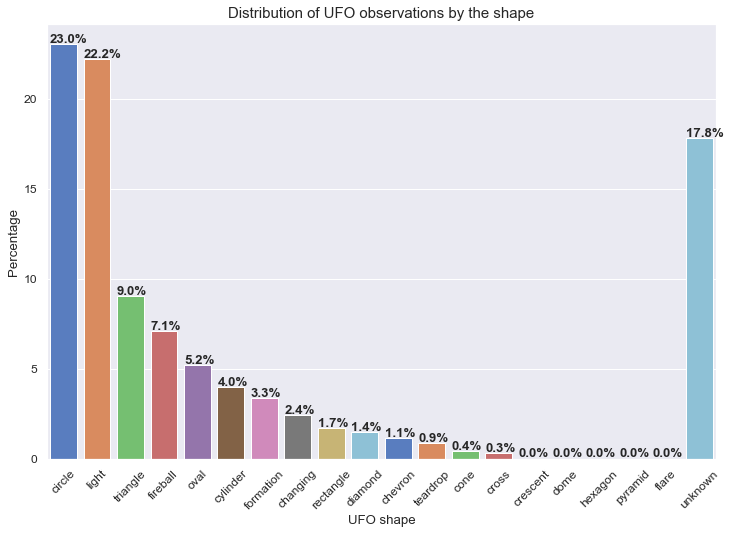

In [78]:
ufo_per_shape = ufo.groupby('Shape')\
        .agg(percentage =('Summary', lambda x: x.size / ufo.shape[0] * 100))\
        .sort_values(by='percentage', ascending=False)\
        .round(2)

idx = ufo_per_shape.index.tolist()
idx.remove('unknown')
ufo_per_shape = ufo_per_shape.reindex(idx + ['unknown'])

sns.set_style("whitegrid")
sns.set(font_scale=1.1)

bar,ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=ufo_per_shape.index,
                 y='percentage',
                 data=ufo_per_shape,
                 ci=None,
                 palette="muted",
                 orient='v', )
ax.set_title("Distribution of UFO observations by the shape", fontsize=15)
ax.set_xlabel ("UFO shape")
ax.set_ylabel ("Percentage")
ax.tick_params(axis='x', rotation=45)

# calculate the percentages and annotate the sns barplot
for rect in ax.patches:
    ax.text(rect.get_x(),rect.get_height() + 0.1,"%.1f%%"% rect.get_height(), weight='bold' );

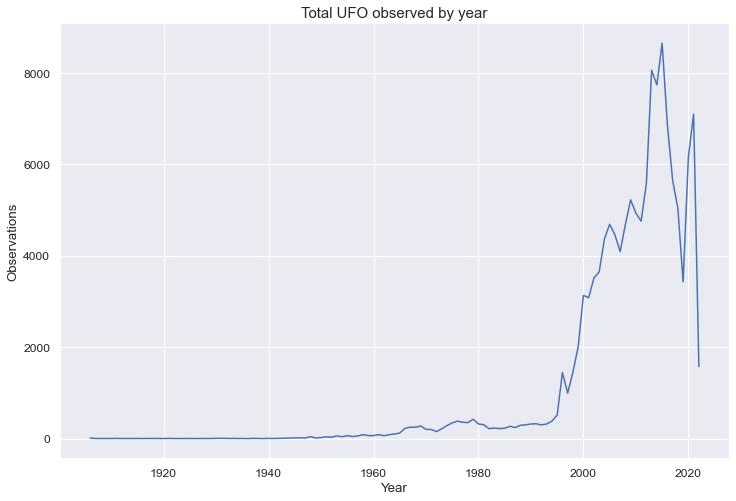

In [79]:
ufo_per_year = ufo.copy()
ufo_per_year.index = ufo.Observed
ufo_per_year = ufo_per_year.resample(rule='Y').Summary.count()

sns.set_style("whitegrid")
sns.set(font_scale=1.1)

plt.figure(figsize=(12,8))
ax = sns.lineplot(x=ufo_per_year.index,
                 y=ufo_per_year,
                 palette="muted")

ax.set_title("Total UFO observed by year", fontsize=15)
ax.set_xlabel ("Year")
ax.set_ylabel ("Observations");

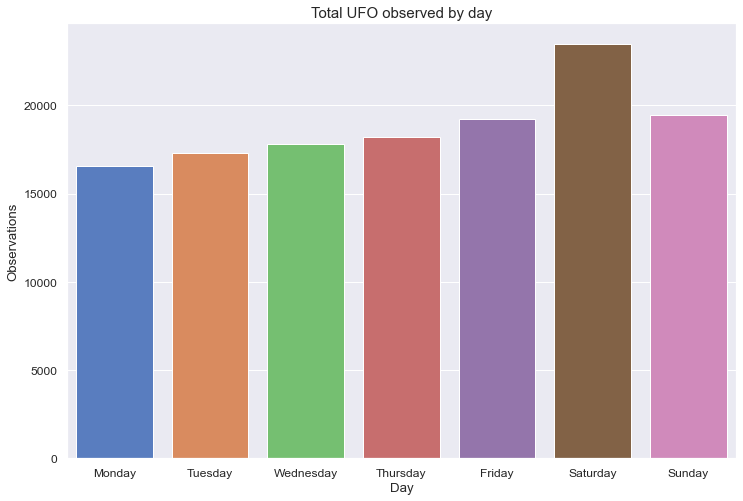

In [140]:
ufo_per_day = ufo.groupby(ufo.Observed.dt.day_name())\
                .Summary\
                .count()\
                .reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

sns.set_style("whitegrid")
sns.set(font_scale=1.1)

plt.figure(figsize=(12,8))
ax = sns.barplot(x=ufo_per_day.index,
                 y=ufo_per_day,
                 palette="muted")

ax.set_title("Total UFO observed by day", fontsize=15)
ax.set_xlabel ("Day")
ax.set_ylabel ("Observations");

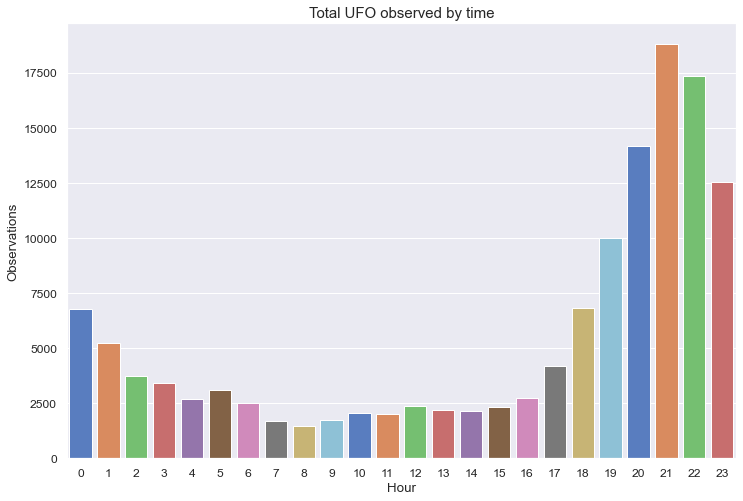

In [143]:
ufo_per_hour = ufo.groupby(ufo.Observed.map(lambda t: t.hour))\
                .Summary\
                .count()

sns.set_style("whitegrid")
sns.set(font_scale=1.1)

plt.figure(figsize=(12,8))
ax = sns.barplot(x=ufo_per_hour.index.astype('int'),
                 y=ufo_per_hour,
                 palette="muted")

ax.set_title("Total UFO observed by time", fontsize=15)
ax.set_xlabel ("Hour")
ax.set_ylabel ("Observations");

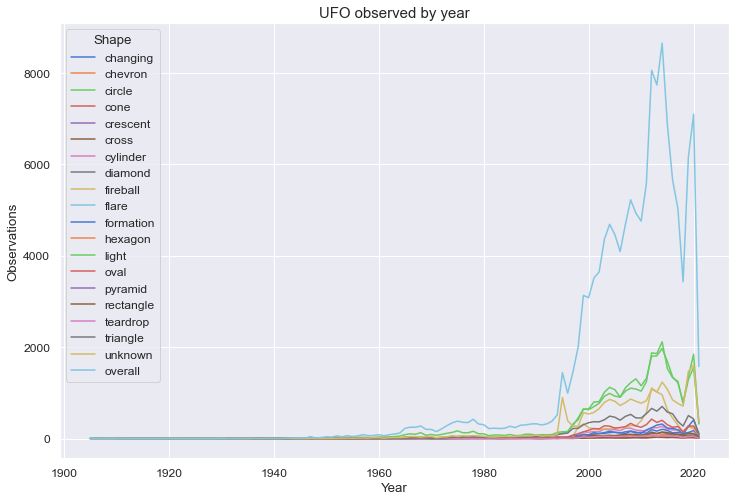

In [80]:
ufo_per_year_shape = ufo.assign(Year = ufo.Observed.dt.year)

ufo_per_year_shape = ufo_per_year_shape.groupby(['Year', 'Shape'], as_index=False)\
        .agg({'Summary': 'count'})\
        .pivot('Year', columns='Shape', values='Summary')

ufo_per_year_shape['overall'] = ufo_per_year_shape.sum(axis=1)

ufo_per_year_shape = ufo_per_year_shape.reset_index()\
    .melt(id_vars = 'Year', var_name='Shape',  value_name='Observations')



sns.set_style("whitegrid")
sns.set(font_scale=1.1)

plt.figure(figsize=(12,8))
ax = sns.lineplot(data=ufo_per_year_shape,
                  x='Year',
                  y='Observations',
                  hue='Shape',
                 palette="muted")

ax.set_title("UFO observed by year", fontsize=15)
ax.set_xlabel ("Year")
ax.set_ylabel ("Observations");

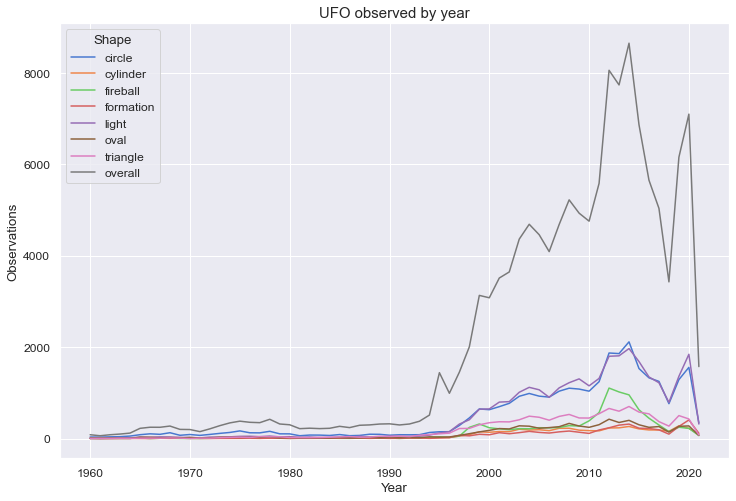

In [81]:
ufo_per_year_shape = ufo.assign(Year = ufo.Observed.dt.year)

ufo_per_year_shape = ufo_per_year_shape.groupby(['Year', 'Shape'], as_index=False)\
        .agg({'Summary': 'count'})\
        .pivot('Year', columns='Shape', values='Summary')

ufo_per_year_shape['overall'] = ufo_per_year_shape.sum(axis=1)

ufo_per_year_shape = ufo_per_year_shape.reset_index()\
    .melt(id_vars = 'Year', var_name='Shape',  value_name='Observations')

ufo_per_year_shape = ufo_per_year_shape.query("Shape in ['overall', 'circle', 'light', 'triangle', 'fireball', 'oval', 'cylinder', 'formation']")\
            .query("1960 <= Year <= 2021")


sns.set_style("whitegrid")
sns.set(font_scale=1.1)

plt.figure(figsize=(12,8))
ax = sns.lineplot(data=ufo_per_year_shape,
                  x='Year',
                  y='Observations',
                  hue='Shape',
                 palette="muted")

ax.set_title("UFO observed by year", fontsize=15)
ax.set_xlabel ("Year")
ax.set_ylabel ("Observations");

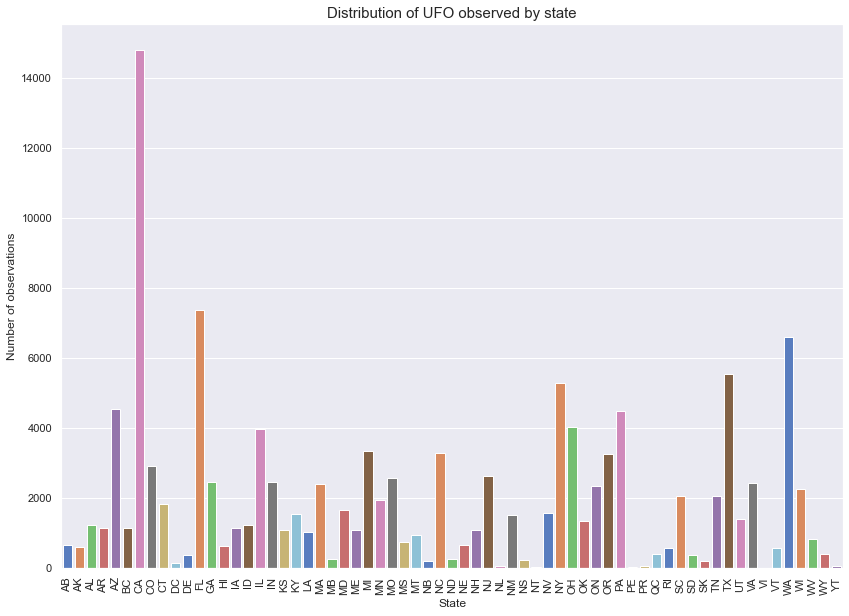

In [82]:
ufo_per_state = ufo.groupby('State', as_index=False)\
        .agg({'Summary': 'count'})\
        .rename(columns={'Summary': 'Observations'})\
        .sort_values(by='State', ascending=True)

#Seaborn barplot
sns.set_style("whitegrid")

sns.set(font_scale=1)

bar,ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(x='State',
                 y='Observations',
                 data=ufo_per_state,
                 ci=None,
                 palette="muted",
                 orient='v')
ax.set_title("Distribution of UFO observed by state", fontsize=15)
ax.set_xlabel ("State")
ax.set_ylabel ("Number of observations")
ax.tick_params(axis='x', rotation=90)

Distribution by state is strongly uneven; let us normalize it to the state population and area

In [83]:
ufo_per_state = pd.merge(left=ufo_per_state, 
                         right=states, how='inner', 
                         left_on='State', 
                         right_on='Abbreviation')

In [84]:
ufo_per_state['Observations_per_population'] = ufo_per_state.Observations / ufo_per_state.Population
ufo_per_state['Observations_per_area'] = ufo_per_state.Observations / ufo_per_state.Total_area
ufo_per_state['Observations_per_land_area'] = ufo_per_state.Observations / ufo_per_state.Land_area

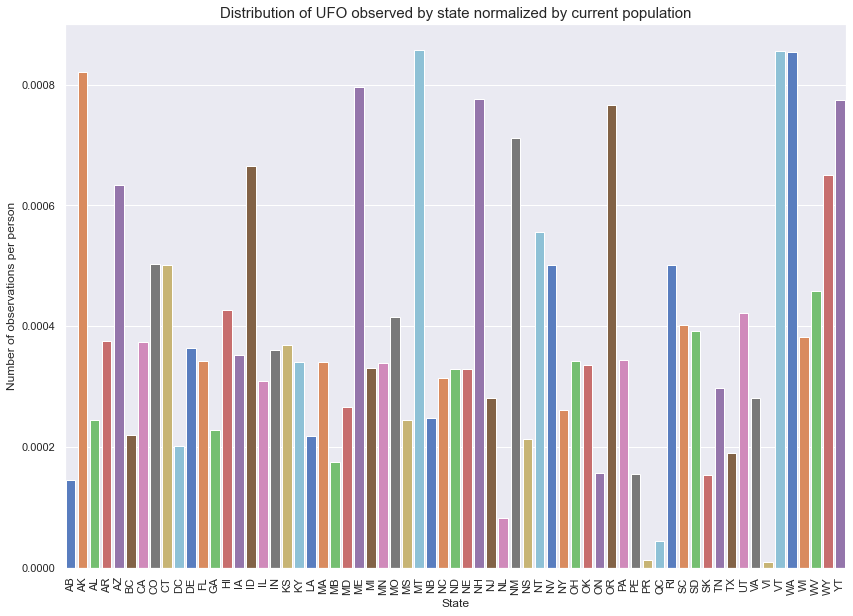

In [85]:
sns.set_style("whitegrid")

sns.set(font_scale=1)

bar,ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(x='State',
                 y='Observations_per_population',
                 data=ufo_per_state,
                 ci=None,
                 palette="muted",
                 orient='v')
ax.set_title("Distribution of UFO observed by state normalized by current population", fontsize=15)
ax.set_xlabel ("State")
ax.set_ylabel ("Number of observations per person")
ax.tick_params(axis='x', rotation=90)

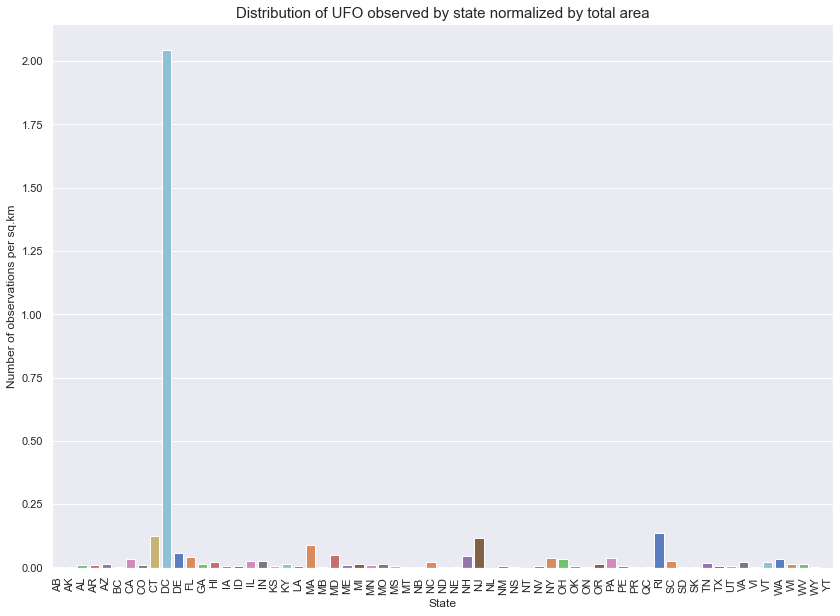

In [86]:
sns.set_style("whitegrid")

sns.set(font_scale=1)

bar,ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(x='State',
                 y='Observations_per_area',
                 data=ufo_per_state,
                 ci=None,
                 palette="muted",
                 orient='v')
ax.set_title("Distribution of UFO observed by state normalized by total area", fontsize=15)
ax.set_xlabel ("State")
ax.set_ylabel ("Number of observations per sq.km")
ax.tick_params(axis='x', rotation=90)

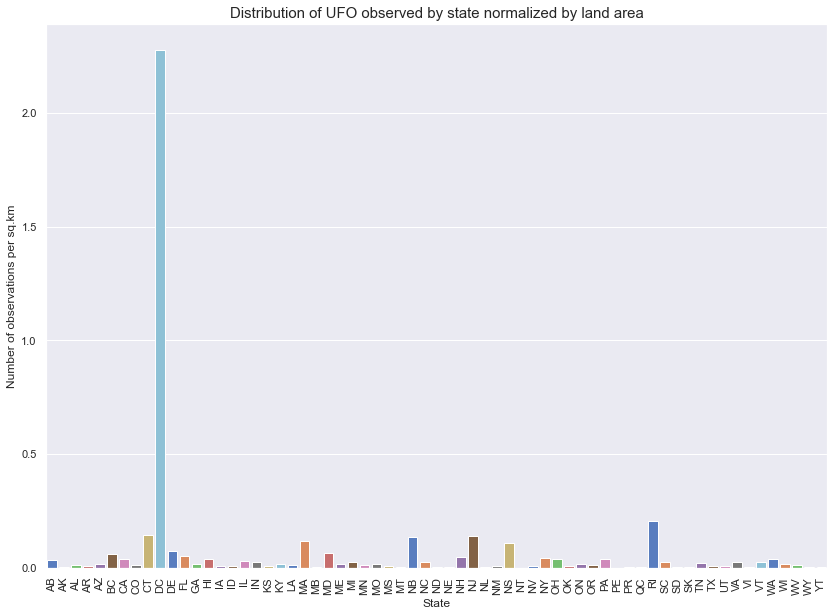

In [87]:
sns.set_style("whitegrid")

sns.set(font_scale=1)

bar,ax = plt.subplots(figsize=(14,10))
ax = sns.barplot(x='State',
                 y='Observations_per_land_area',
                 data=ufo_per_state,
                 ci=None,
                 palette="muted",
                 orient='v')
ax.set_title("Distribution of UFO observed by state normalized by land area", fontsize=15)
ax.set_xlabel ("State")
ax.set_ylabel ("Number of observations per sq.km")
ax.tick_params(axis='x', rotation=90)

In [97]:
def z_score(column):
    column.replace([np.inf, -np.inf], np.nan, inplace=True)
    return (column - column.mean())/column.std()

ufo_per_state['Observations_std'] = z_score(ufo_per_state['Observations'])
ufo_per_state['Observations_per_population_std'] = z_score(ufo_per_state['Observations_per_population'])
ufo_per_state['Observations_per_area_std'] = z_score(ufo_per_state['Observations_per_area'])
ufo_per_state['Observations_per_land_area_std'] = z_score(ufo_per_state['Observations_per_land_area'])

std_observations = ufo_per_state.loc[:, ['State', 'Observations_std', 'Observations_per_population_std', 'Observations_per_area_std', 'Observations_per_land_area_std']]

std_observations = pd.melt(frame=std_observations, 
        id_vars='State',
        value_vars=['Observations_std', 'Observations_per_population_std', 'Observations_per_area_std', 'Observations_per_land_area_std'],
        )

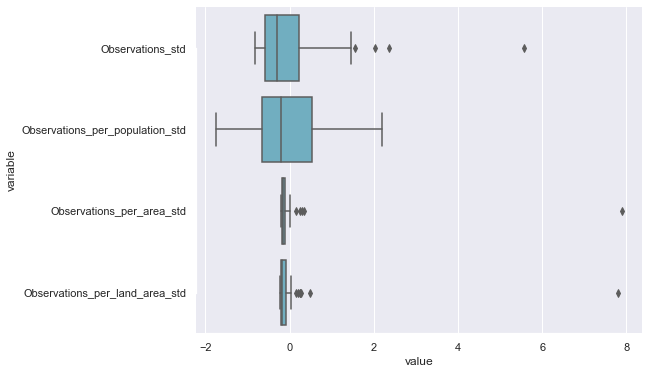

In [98]:
plt.figure(figsize=(8,6))
sns.boxplot(x="value", y="variable", data=std_observations, color="c")
sns.despine(trim=True)

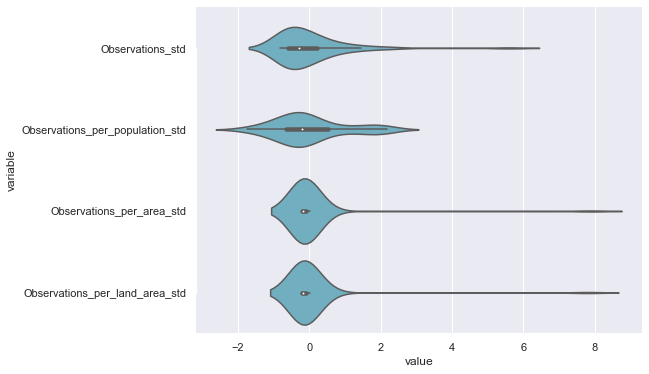

In [99]:
plt.figure(figsize=(8,6))
sns.violinplot(x="value", y="variable", data=std_observations, color="c")
sns.despine(trim=True)

In [106]:
std_observations.query("variable == 'Observations_per_population_std'").value

65    -1.125210
66     2.016161
67    -0.660049
68    -0.051897
69     1.143815
         ...   
125    2.171767
126   -0.021503
127    0.334820
128    1.223081
129    1.801947
Name: value, Length: 65, dtype: float64

In [113]:
fig = px.choropleth(locations=std_observations.query("variable == 'Observations_per_population_std'").State,
                    locationmode="USA-states",
                    color=std_observations.query("variable == 'Observations_per_population_std'").value,
                    scope="usa",
                    title='Z-score of UFO observations per current state population')
fig.show()

In [111]:
fig = px.choropleth(locations=std_observations.query("variable == 'Observations_per_area_std'")\
                                              .State,
                    locationmode="USA-states",
                    color=std_observations.query("variable == 'Observations_per_area_std'")\
                                           .value,
                    scope="usa")
fig.show()

In [112]:
fig = px.choropleth(locations=std_observations.query("variable == 'Observations_per_area_std'")\
                                              .query("abs(value) < 1")\
                                              .State,
                    locationmode="USA-states",
                    color=std_observations.query("variable == 'Observations_per_area_std'")\
                                           .query("abs(value) < 1")\
                                           .value,
                    scope="usa")
fig.show()

![historical population in USA by state]("https://upload.wikimedia.org/wikipedia/commons/f/f3/US_state_historical_population_FRED_SMIL.svg")

In [120]:
import ipyplot

ipyplot.plot_images(
    ['https://upload.wikimedia.org/wikipedia/commons/f/f3/US_state_historical_population_FRED_SMIL.svg'], # images should be passed in as an array
    img_width=800)

In [153]:
ufo.groupby(['State', 'City']).Posted.count().sort_values(ascending=False)[:40]

State  City                    
AZ     Phoenix                     718
WA     Seattle                     697
NV     Las Vegas                   591
OR     Portland                    543
CA     San Diego                   500
       Los Angeles                 494
AZ     Tucson                      412
IL     Chicago                     408
TX     Houston                     400
NM     Albuquerque                 371
FL     Orlando                     355
       Miami                       328
TX     Austin                      316
ID     Boise                       306
CO     Denver                      306
CA     Sacramento                  294
SC     Myrtle Beach                285
CA     San Jose                    267
TX     San Antonio                 257
OH     Columbus                    246
CO     Colorado Springs            246
ON     Toronto (Canada)            245
FL     Jacksonville                240
CA     San Francisco               237
AZ     Mesa                     

In [152]:
ufo.query('State == "DC"').groupby(['State', 'City']).Posted.count().sort_values(ascending=False)[:20]

State  City                                    
DC     Washington, D.C.                            107
       Washington                                   10
       Washington, DC                                4
       Caracas (Venezuela)                           2
       Washington, D.C. (area)                       2
       Washington, D.C. (Roosevelt Island Area)      1
       Wilmington                                    1
       WashingtonWhite House                         1
       Washington, D.C. to Kansas City               1
       Washington, D.C. (above I-295 bridge)         1
       Washington, D.C. (Capitol Hill)               1
       Washington, D.C. (Georgetown)                 1
       Georgetown                                    1
       Washington, D.C. (6 miles west of)            1
       Rehoboth Beach                                1
       México                                        1
       Meppel (Netherlands)                          1
       Maroochydo

In [165]:
us_states = states.iloc[:56]
canada_states = states.iloc[56:]

In [167]:
ufo_us = ufo.query('State in @us_states.Abbreviation')
ufo_canada = ufo.query('State in @canada_states.Abbreviation')
ufo_dc = ufo_us.query('State == "DC"')
ufo_no_dc = ufo_us.query('State != "DC"')

In [181]:
ufo_us_per_hour = ufo_us.groupby(ufo_us.Observed.map(lambda t: t.hour))\
                .Summary\
                .count()

ufo_canada_per_hour = ufo_canada.groupby(ufo_canada.Observed.map(lambda t: t.hour))\
                .Summary\
                .count()

ufo_dc_per_hour = ufo_dc.groupby(ufo_dc.Observed.map(lambda t: t.hour))\
                .Summary\
                .count()

ufo_no_dc_per_hour = ufo_no_dc.groupby(ufo_no_dc.Observed.map(lambda t: t.hour))\
                .Summary\
                .count()


ufo_us_per_hour = pd.DataFrame({
    'Observations': ufo_us_per_hour / ufo_us_per_hour.sum(),
    'Region': 'US'
            })

ufo_canada_per_hour = pd.DataFrame({
    'Observations': ufo_canada_per_hour / ufo_canada_per_hour.sum(),
    'Region': 'Canada'
            })

ufo_dc_per_hour = pd.DataFrame({
    'Observations': ufo_dc_per_hour / ufo_dc_per_hour.sum(),
    'Region': 'DC'
            })

ufo_no_dc_per_hour = pd.DataFrame({
    'Observations': ufo_no_dc_per_hour / ufo_no_dc_per_hour.sum(),
    'Region': 'US outside DC'
            })



ufo_region_hour = pd.concat([ufo_us_per_hour, ufo_canada_per_hour, ufo_dc_per_hour, ufo_no_dc_per_hour])


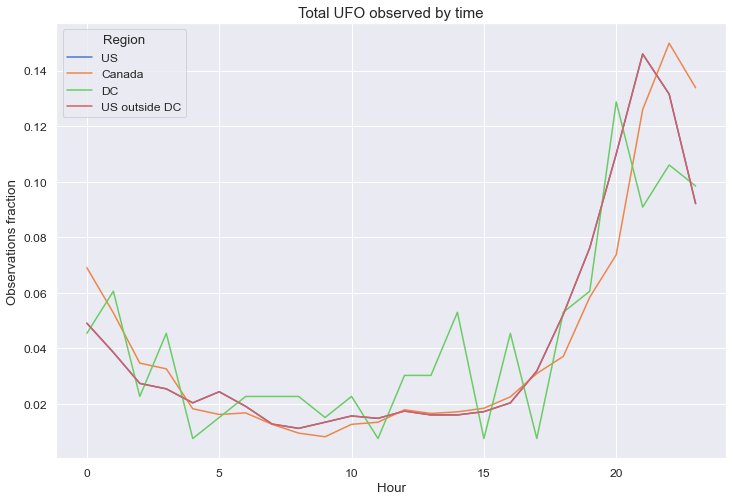

In [183]:
sns.set_style("whitegrid")
sns.set(font_scale=1.1)

plt.figure(figsize=(12,8))
ax = sns.lineplot(x=ufo_region_hour.index.astype('int'),
                 y=ufo_region_hour.Observations,
                 hue=ufo_region_hour.Region, 
                 palette="muted")

ax.set_title("Total UFO observed by time", fontsize=15)
ax.set_xlabel ("Hour")
ax.set_ylabel ("Observations fraction");

In [191]:
ufo_us_per_shape = ufo_us.groupby('Shape')\
        .agg(percentage =('Summary', lambda x: x.size / ufo_us.shape[0] * 100))\
        .sort_values(by='percentage', ascending=False)\
        .round(2)
ufo_us_per_shape['Region'] = 'US'


ufo_canada_per_shape = ufo_canada.groupby('Shape')\
        .agg(percentage =('Summary', lambda x: x.size / ufo_canada.shape[0] * 100))\
        .sort_values(by='percentage', ascending=False)\
        .round(2)
ufo_canada_per_shape['Region'] = 'Canada'

ufo_dc_per_shape = ufo_dc.groupby('Shape')\
        .agg(percentage =('Summary', lambda x: x.size / ufo_dc.shape[0] * 100))\
        .sort_values(by='percentage', ascending=False)\
        .round(2)
ufo_dc_per_shape['Region'] = 'DC'

ufo_no_dc_per_shape = ufo_no_dc.groupby('Shape')\
        .agg(percentage =('Summary', lambda x: x.size / ufo_no_dc.shape[0] * 100))\
        .sort_values(by='percentage', ascending=False)\
        .round(2)
ufo_no_dc_per_shape['Region'] = 'US outside DC'

ufo_region_shape = pd.concat([ufo_us_per_shape, ufo_canada_per_shape, ufo_dc_per_shape, ufo_no_dc_per_shape])

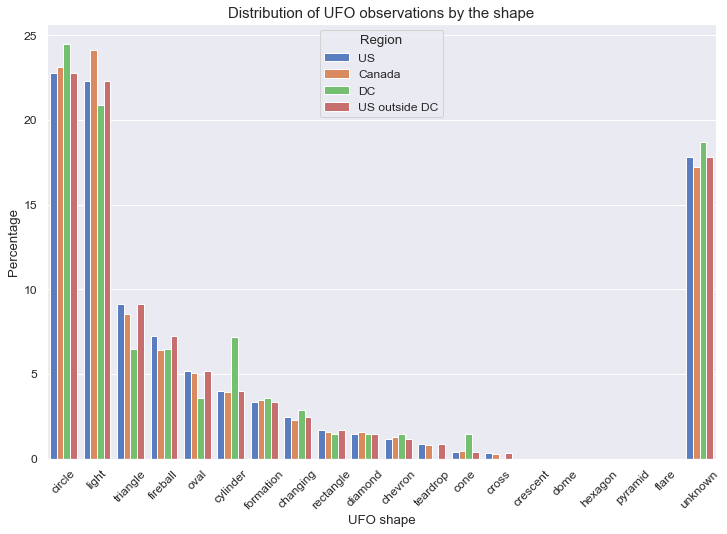

In [194]:
idx = ufo_per_shape.index.tolist()
idx.remove('unknown')
idx.append('unknown')



sns.set_style("whitegrid")
sns.set(font_scale=1.1)

bar,ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=ufo_region_shape.index,
                 y='percentage',
                 data=ufo_region_shape,
                 hue='Region',
                 ci=None,
                 palette="muted",
                 orient='v',
                 order=idx)
ax.set_title("Distribution of UFO observations by the shape", fontsize=15)
ax.set_xlabel ("UFO shape")
ax.set_ylabel ("Percentage")
ax.tick_params(axis='x', rotation=45)

# calculate the percentages and annotate the sns barplot
# for rect in ax.patches:
#     ax.text(rect.get_x(),rect.get_height() + 0.1,"%.1f%%"% rect.get_height(), weight='bold' );